# Trial by trial fit of InSpe data for searchlight classificiation
This tutorial will load models and data from tutorial 15 and change the design matrix to one that gives a beta estimate for each trial.
It then conducts a searchlight classification analysis and finds the best performing voxels.
Lastly, it conducts a permutation test on a test data set, selecting the best voxels.

## NB. The searchlight analysis takes a long time to run and uses a lot of memory.
If you want to use this script, please consider:
- converting to .py and running using tmux (see `xx_tmux_notes.ipynb`)
- using a machine with more RAM (48GB?)
- being patient (will take at least 10 hours).

In [ ]:
#Convert notebook ot .py for running from terminal
!jupyter nbconvert --to python /work/857248/16_Nilearn_InSpe_classification_single_sub.ipynb

<div class="alert alert-success" role="alert">

# Preamble: Activate environment
In the first notebook, we installed a python environment. If you haven't don so, please go back to the ```01_setup_virtual_environment.ipynb``` and complete this before proceeding.

If you closed/stopped the UCloud run between then and now, we will need to reactivate the environment.

For this we use a bash script with a subset of the lines we used for setting up the environment

The script called ```activate.sh``` This should be located in your working directory. If not, save the following in a file with this filename.

```bash
. /work/<MY DIRECTORY NUMBER>/virt_env/bin/activate
python -m ipykernel install --user --name=virt_env
echo Done! Remember changing the kernel in Jupyter.
```
</div>

In [1]:
import os
path='/work/798873' # Remember to change this to your own path
os.chdir(path)
!./activate.sh


Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


<div class="alert alert-success" role="alert">
    
### Check that we are in the right environment

</div>

In [2]:
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn


/work/anton_folder/env/bin/python


In [3]:
# Additional imports
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas as pd

#### Importing data and models from tutorial 15
The data in tutorial 15 were analysed to not include the self/other distinction. If you want to study that, you need to edit the event names.

In [4]:
import pickle

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

f = open('/work/MikkelWallentin#6287/InSpe_first_level_models.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()



now = datetime.now()
print('Loaded models:',now.strftime("%H:%M:%S"))

Starting cell: 13:08:12
Loaded models: 13:08:15


### Figuring out what is in the models_events variable

In [5]:
# Inspect number of scans and confounds included in the first participant, first run:
print(models_confounds[0][0].shape)
# Inspect number of trials, onsets and trial types for the first participant, first run:
print(models_events[0][0])


(490, 22)
         onset  duration trial_type
0     1.020684  0.683998          N
1     6.321974  0.699943          B
2    12.638653  0.700180          N
3    17.955595  0.699861          B
4    24.272967  0.699784          P
..         ...       ...        ...
85  450.943761  0.699872          B
86  457.261032  0.699568          B
87  461.577604  0.700333          B
88  467.894874  0.699702          P
89  474.211758  0.700543          P

[90 rows x 3 columns]


## Creating new design matrices with a column per experimental trial.

In [6]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
lsa_dm=[]

# Changing the model for a single participant (the first):
for ii in range(len(models_events[0])):
    # Sort onsets by trial type to make later processing easier
    #models_events[0][ii].sort_values(by=['trial_type'], inplace=True)
     #N=number of events
    N=models_events[0][ii].shape[0]
    # time frame with 490 scans with 1s TR:
    t_fmri = np.linspace(0, 490,490,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(models_events[0][ii], columns=['onset'])
    trials.loc[:, 'duration'] = 0.7
    trials.loc[:, 'trial_type'] = [models_events[0][ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[0][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))
    




now = datetime.now()
print('Finish making single trial models:',now.strftime("%H:%M:%S"))

Finish making single trial models: 13:08:20


### Check out the created design matrix
Note that the index represents the frame times

In [7]:
print(lsa_dm[0])

       B_t_002  B_t_004  B_t_006  B_t_015  B_t_016  B_t_018  B_t_020  B_t_021  \
0.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
485.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
486.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
487.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
488.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
489.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       B_t_023  B_t_033  ..

## Plot the new design matrices

Finishing cell: 13:08:23


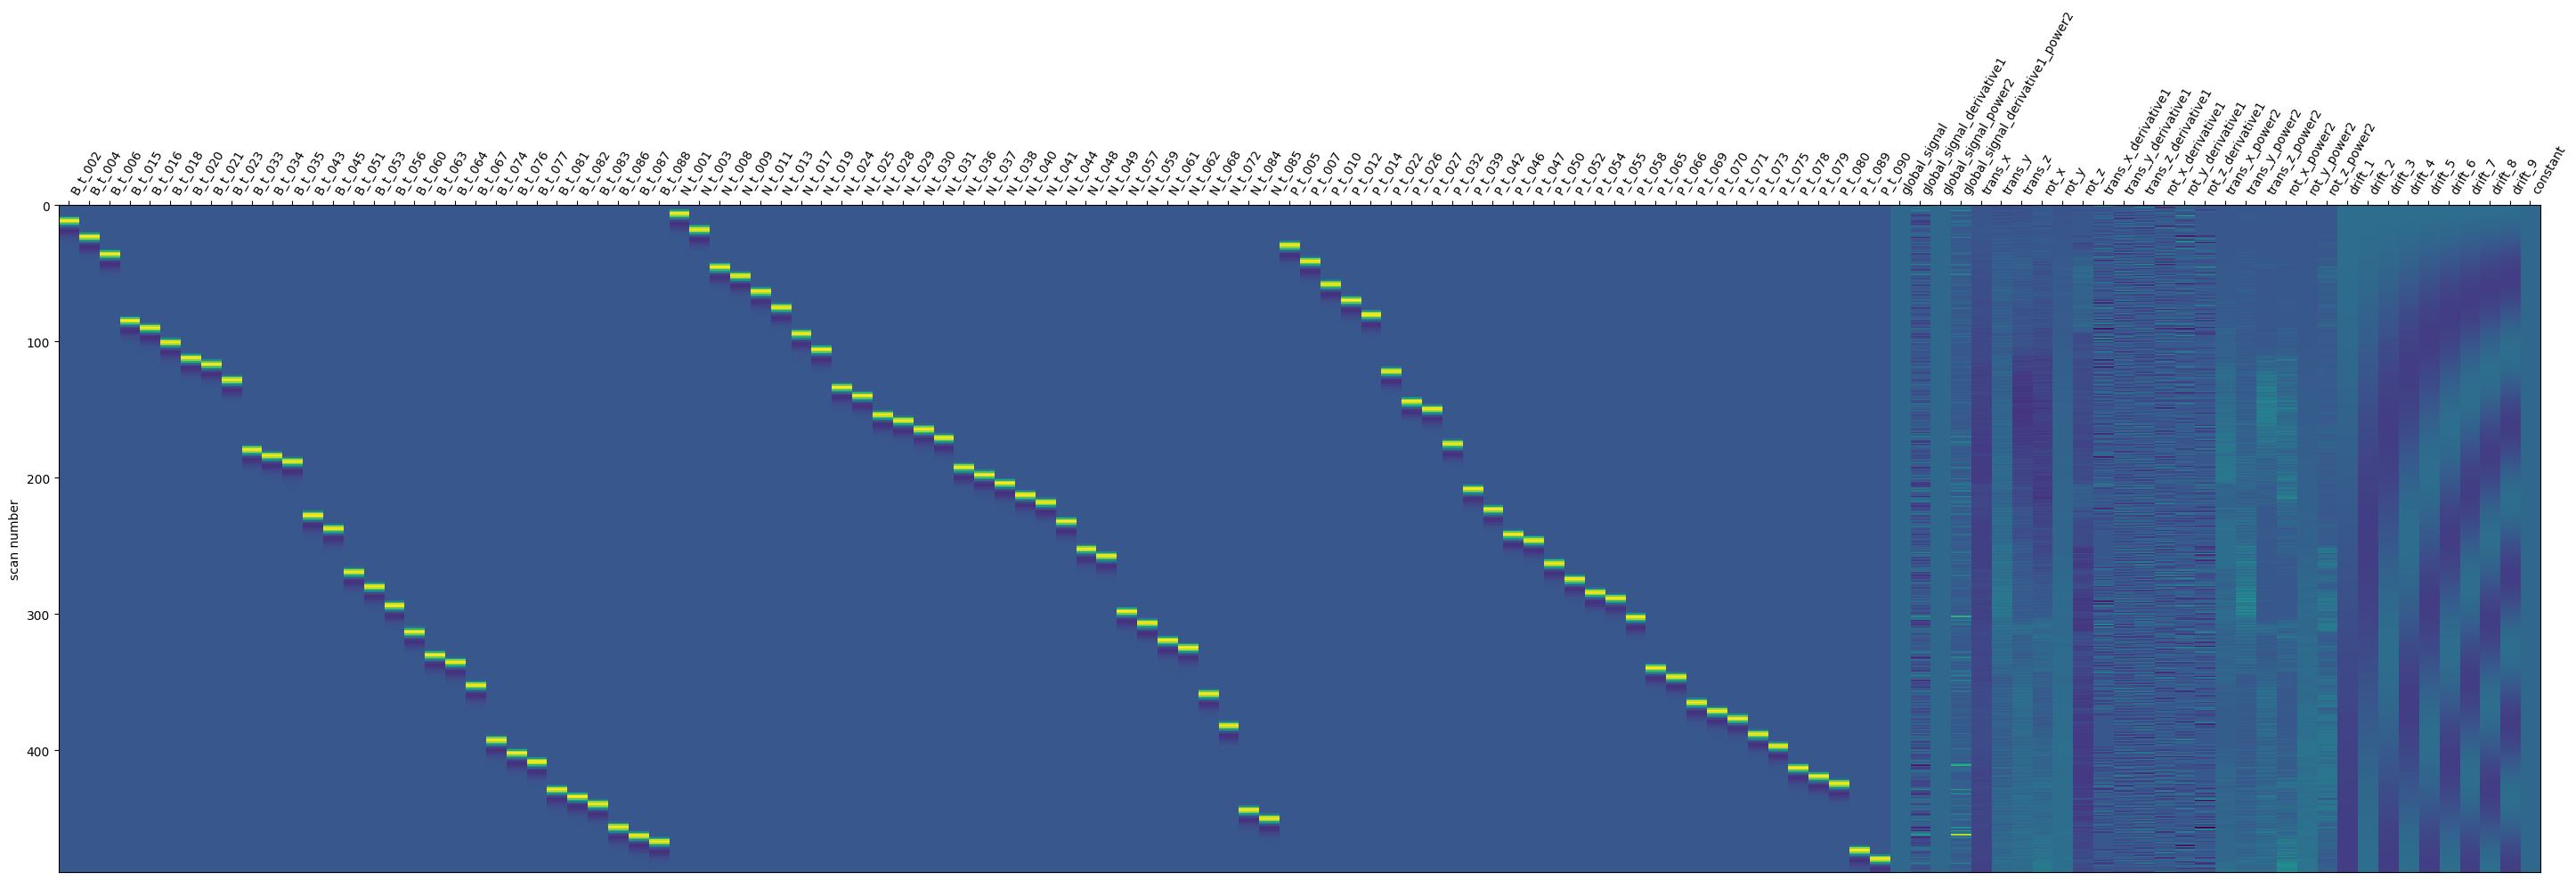

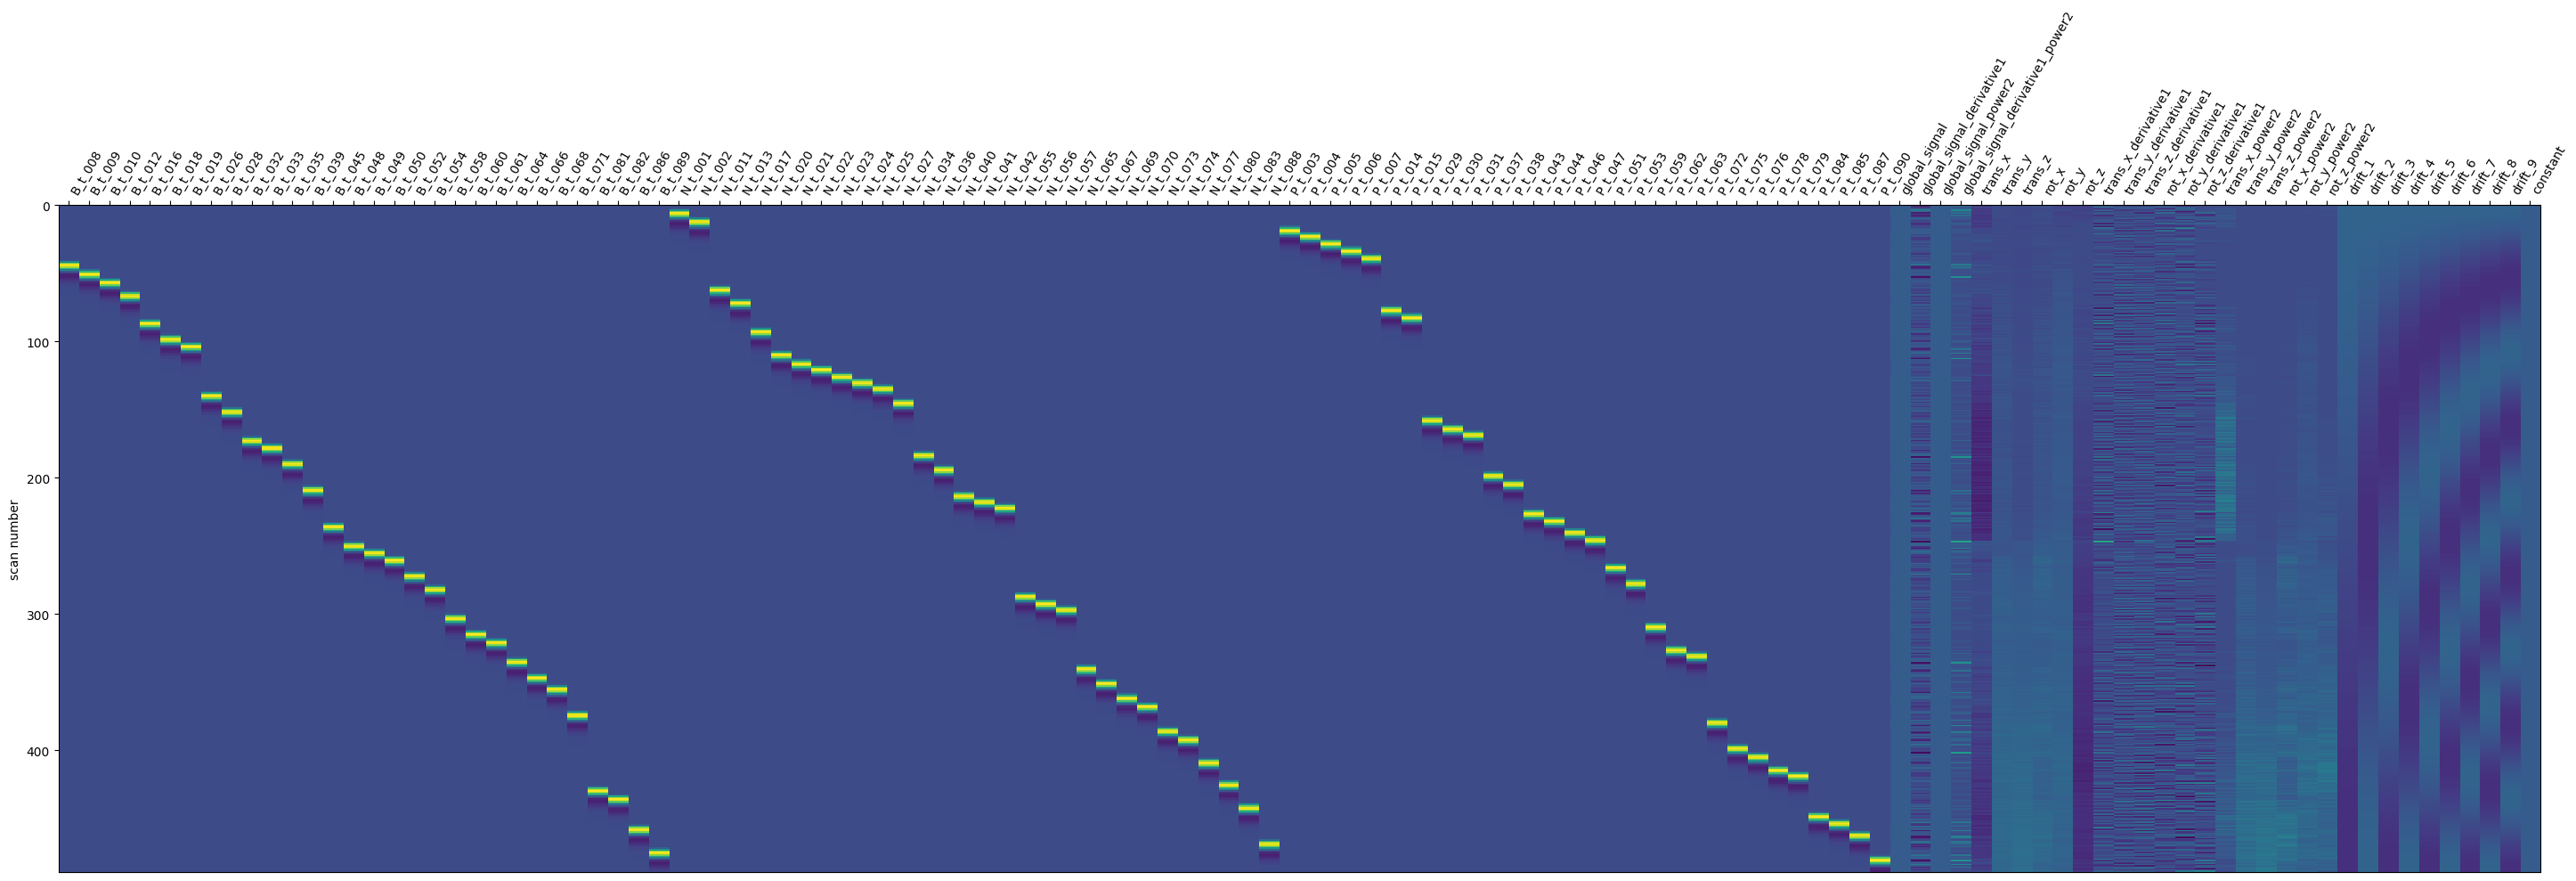

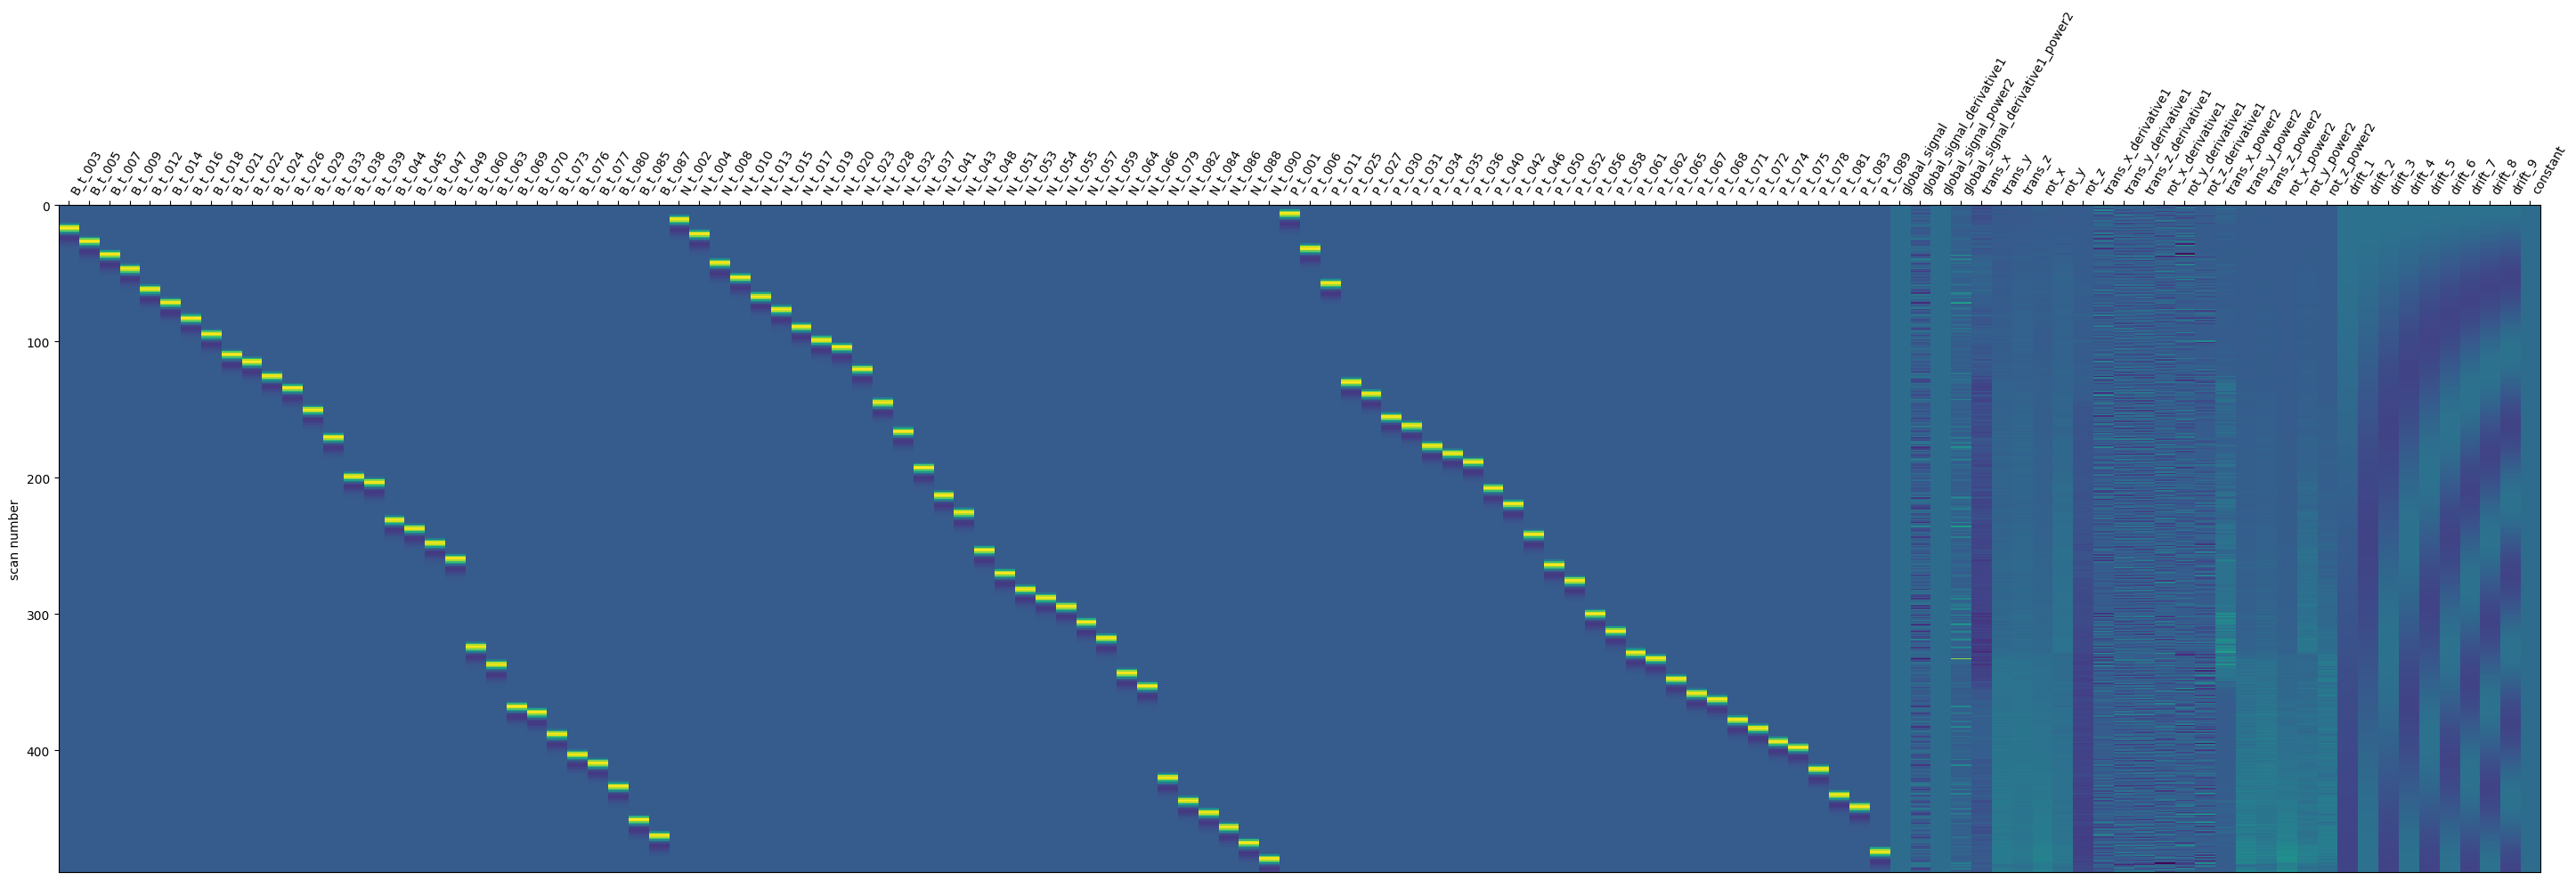

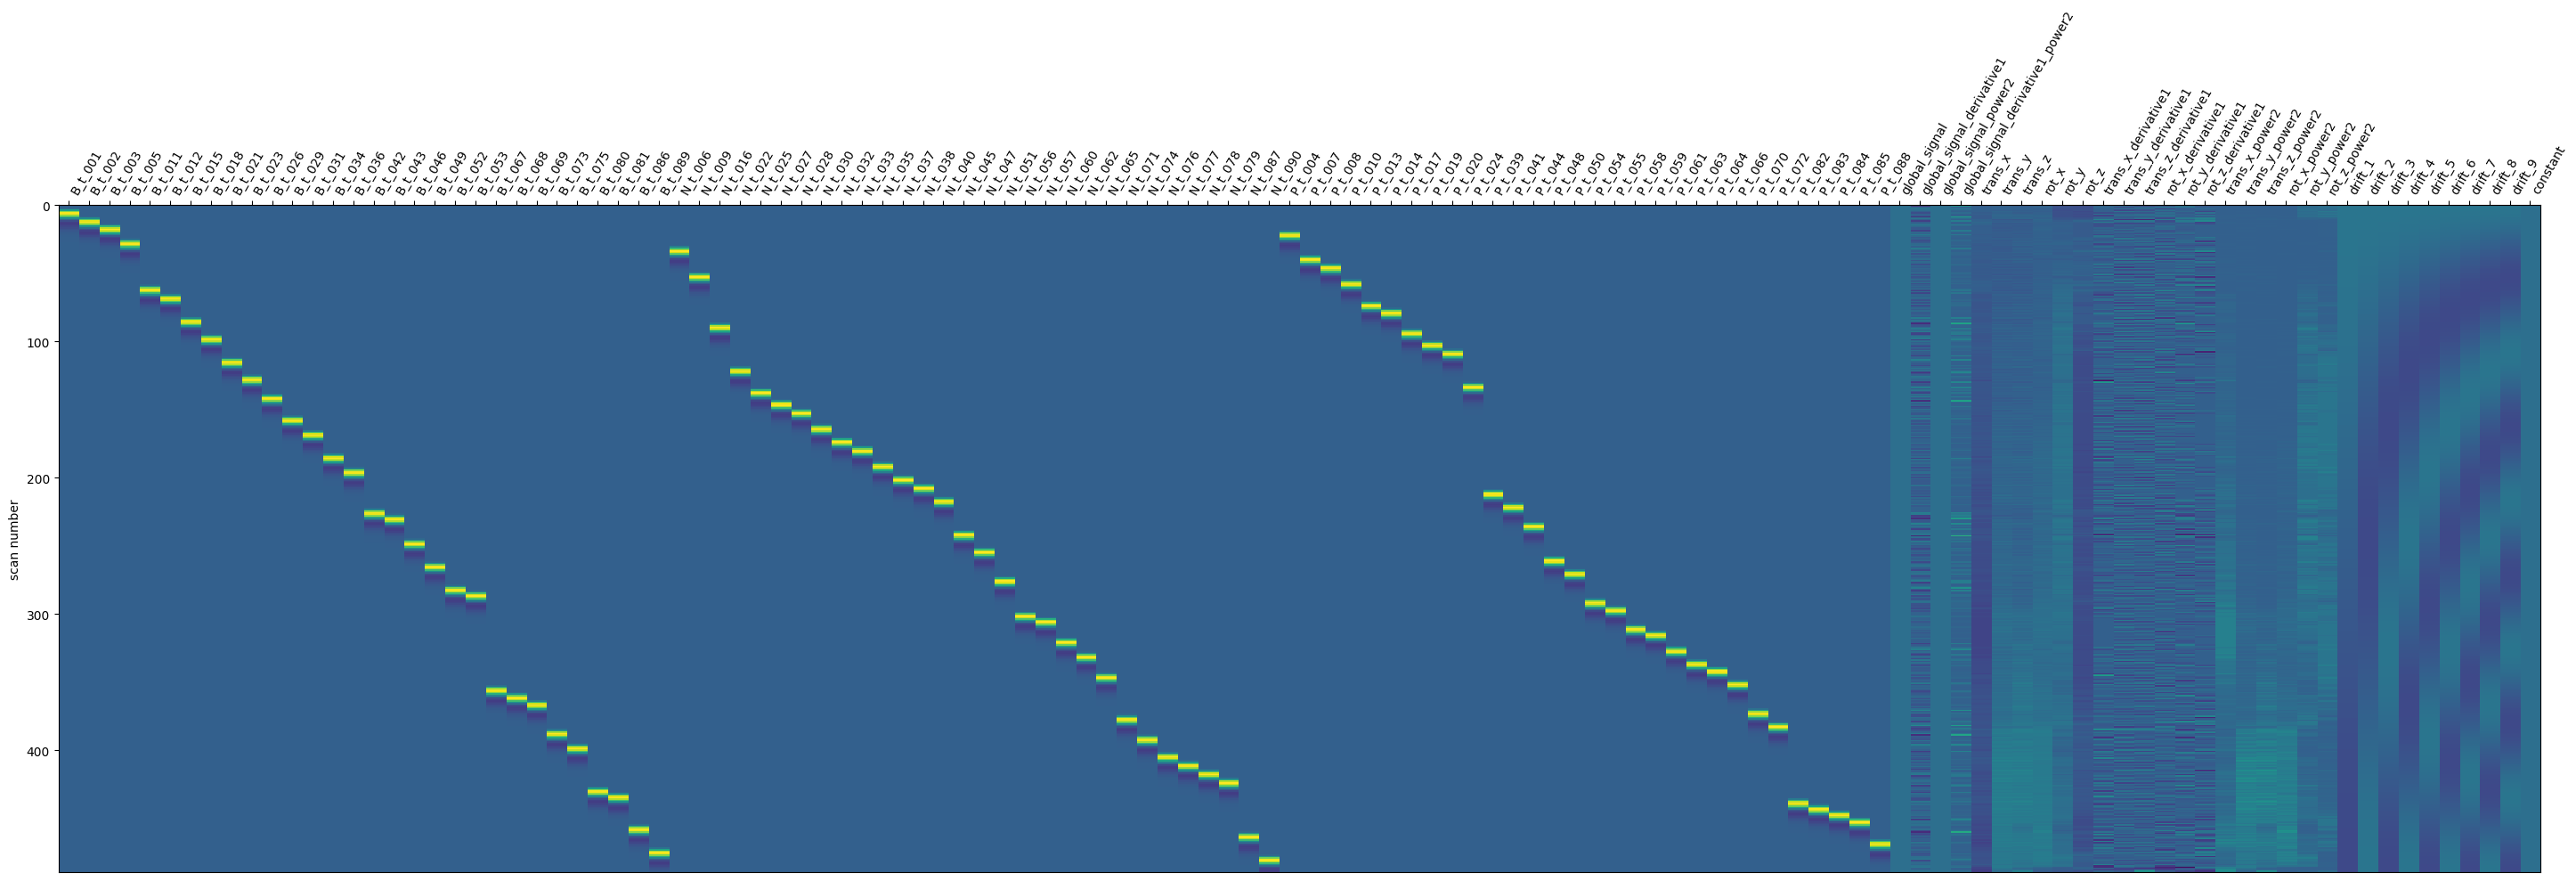

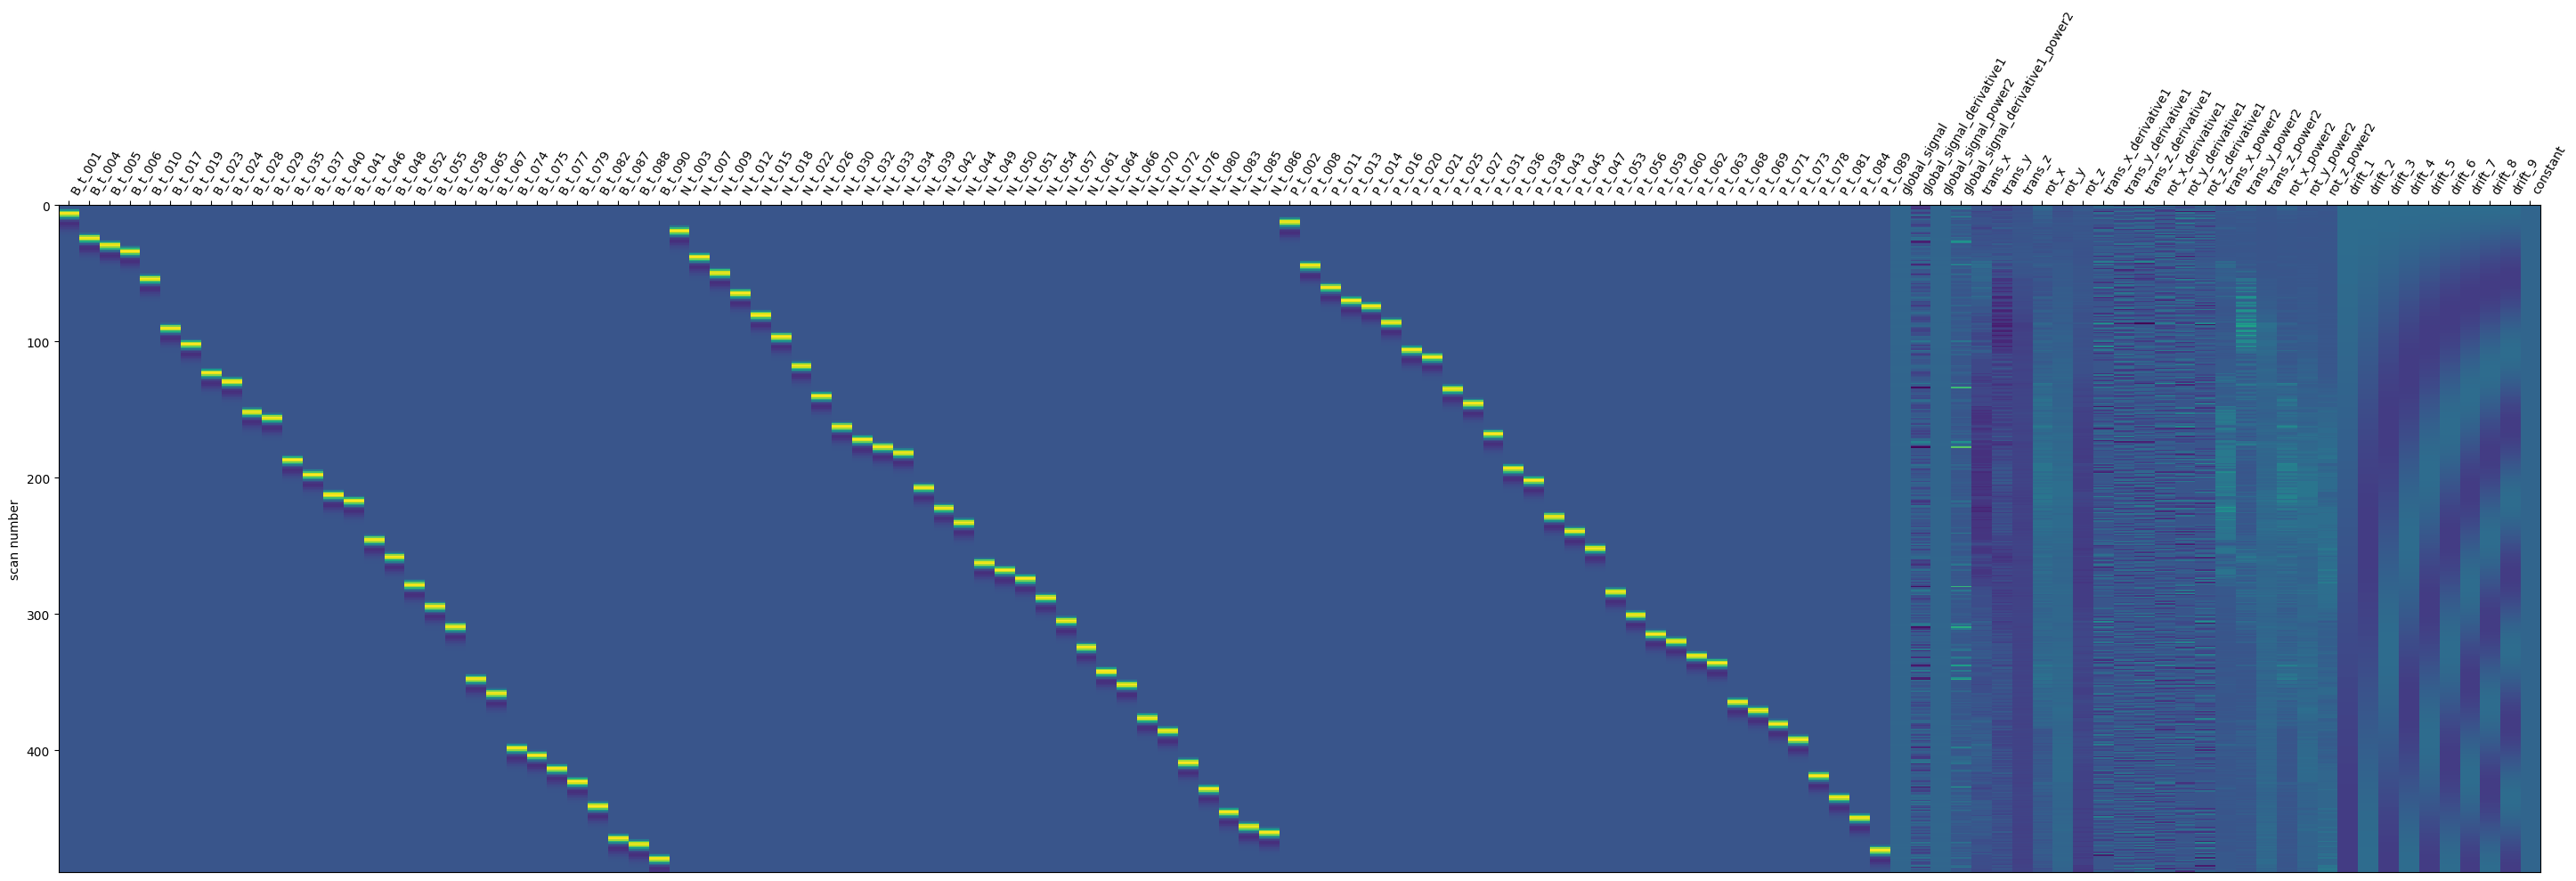

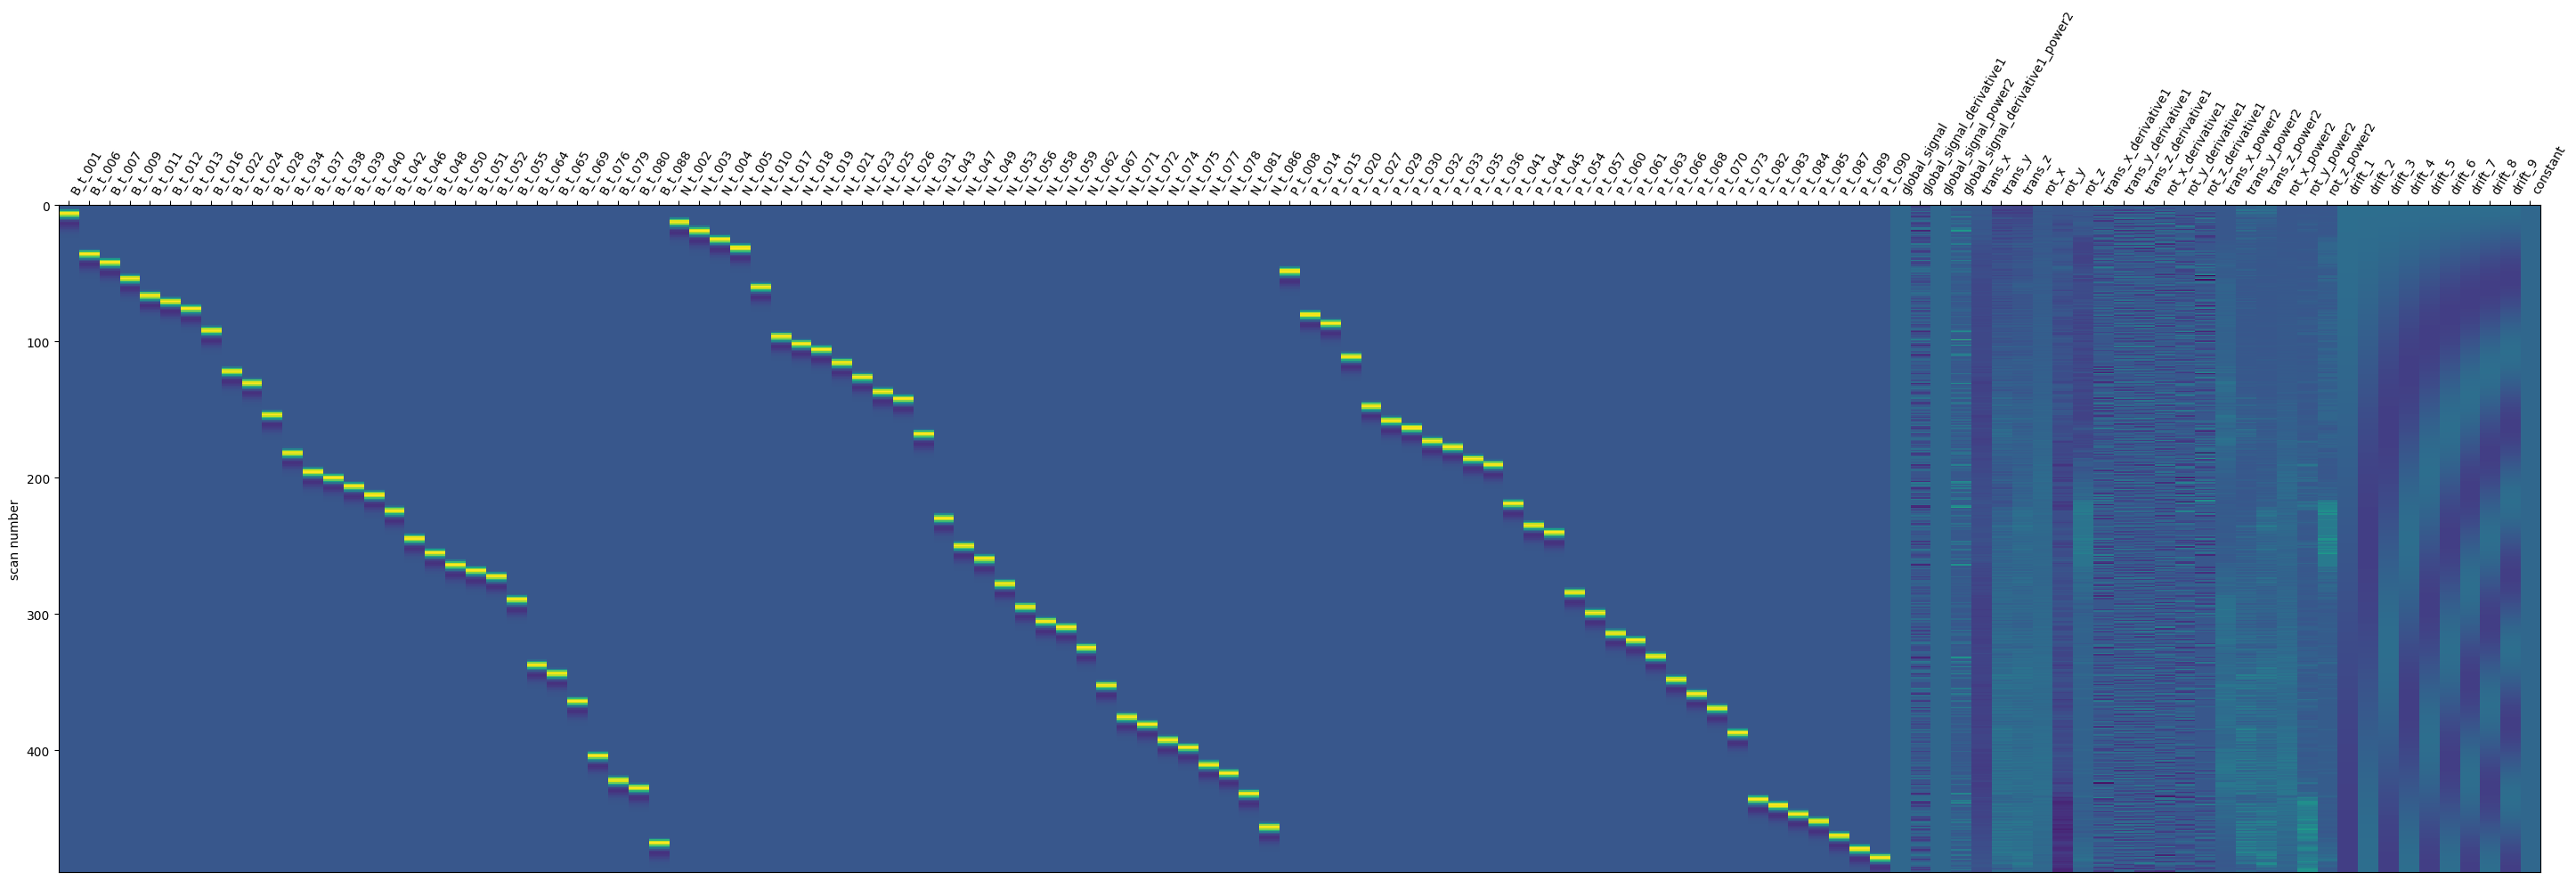

In [8]:
from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[0])):
    plot_design_matrix(lsa_dm[ii]);

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Let's inspect the correlational structure of the design matrix

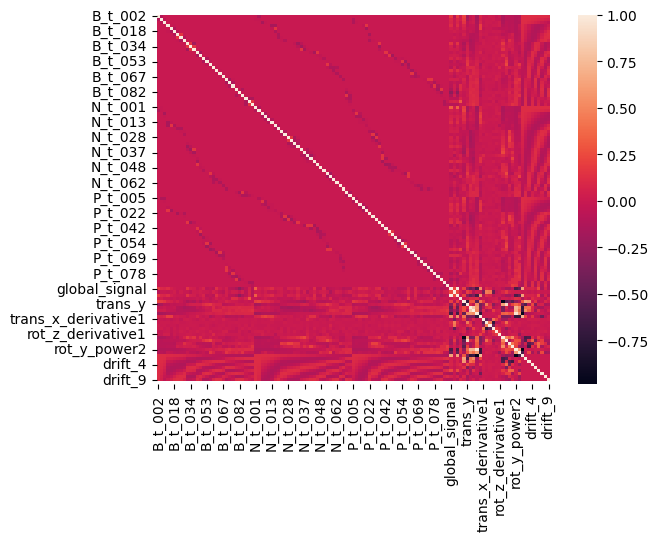

In [9]:
import seaborn as sns
dm_corr=lsa_dm[0].corr()
p1 = sns.heatmap(dm_corr)

## Fit the models for all sessions from one participant

In [10]:

from nilearn.glm.first_level import FirstLevelModel

model1=[]
for ii in range(len(models_events[0])):
    
    # Get data and model info for 1st participant, 1st session
    imgs1=models_run_imgs[0][ii]
    model1.append (FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model1[ii].fit(imgs1,design_matrices=lsa_dm[ii])

now = datetime.now()
print('Finishing model fit:',now.strftime("%H:%M:%S"))

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Fitting GLM:  5
Fitting GLM:  6
Finishing model model fit: 13:17:05


## Saving/retrieving the fitted models and design matrices

In [11]:
import pickle

# Saving the objects:
f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm], f)
f.close()

## Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'rb')
#model1, lsa_dm = pickle.load(f)
#f.close()

#print(model1[0])
now = datetime.now()
print('Saved model and design matrices:',now.strftime("%H:%M:%S"))

Saved model and design matrices: 13:17:06


## Making beta map contrasts from the fitted model to use in later analyses

In [12]:
now = datetime.now()
print('Computing contrasts:',now.strftime("%H:%M:%S"))
b_maps = []
conditions_label = []

for ii in range(len(models_events[0])):
    N=models_events[0][ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    #print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    #print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    #print(contrasts.shape)
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        #Add a beta-contrast image from each trial
        b_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])
#        session_label.append(session)

now = datetime.now()
print('Done computing contrasts:',now.strftime("%H:%M:%S"))


Computing contrasts: 13:17:06
Making contrasts for session :  1
Number of contrasts :  90
Making contrasts for session :  2
Number of contrasts :  90
Making contrasts for session :  3
Number of contrasts :  90
Making contrasts for session :  4
Number of contrasts :  90
Making contrasts for session :  5
Number of contrasts :  90
Making contrasts for session :  6
Number of contrasts :  90
Done computing contrasts: 13:35:22


## Saving models and beta maps

In [13]:
import pickle

#Save the first level models

# Saving the objects:
f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm, conditions_label, b_maps], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'rb')
#model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
#f.close()

now = datetime.now()
print('Saved beta-maps:',now.strftime("%H:%M:%S"))

del model1

Saved beta-maps: 13:35:26


## Reshape data for classification
Checking that the design matrix and the condition labels look the same.

In [19]:
print('Checking that column names for design matrix matches labels')
print(lsa_dm[0].columns[0:9])
print(conditions_label[0:9])

Checking that column names for design matrix matches labels
Index(['B_t_002', 'B_t_004', 'B_t_006', 'B_t_015', 'B_t_016', 'B_t_018',
       'B_t_020', 'B_t_021', 'B_t_023'],
      dtype='object')
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']


Selecting Positive and negative trials

In [20]:

now = datetime.now()
print('Renaming labels to N, P, and B:',now.strftime("%H:%M:%S"))

f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

import numpy as np
#from nilearn import datasets
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from sklearn.model_selection import train_test_split, GroupKFold
n_trials=len(conditions_label)
#print(n_trials)

#Concatenate beta maps
b_maps_conc=concat_imgs(b_maps)
#print(b_maps_conc.shape)
del b_maps
# Reshaping data------------------------------
from nilearn.image import index_img, concat_imgs
#Find all negative and positive trials
idx_neg=[int(i) for i in range(len(conditions_label)) if 'N_' in conditions_label[i]]
idx_pos=[int(i) for i in range(len(conditions_label)) if 'P_' in conditions_label[i]]
idx_but=[int(i) for i in range(len(conditions_label)) if 'B_' in conditions_label[i]]

#print(idx_neg)
#print(conditions_label)
for i in range(len(conditions_label)):
    if i in idx_neg:
        conditions_label[i]='N'
    if i in idx_pos:
        conditions_label[i]='P'
    if i in idx_but:
        conditions_label[i]='B'
print(conditions_label)

now = datetime.now()
print('Selecting to N and B:',now.strftime("%H:%M:%S"))
# Make index of relevant trials
idx=np.concatenate((idx_neg, idx_but))
#print(idx)

#Select trials
conditions=np.array(conditions_label)[idx]
print(conditions)

#Select images
b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)


Renaming labels to N, P, and B: 13:39:36
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'

## create training and testing vars on the basis of class labels

In [21]:
now = datetime.now()
print('Making a trial and test set:',now.strftime("%H:%M:%S"))
#conditions_img=conditions[idx]
#print(conditions_img)
#Make an index for spliting fMRI data with same size as class labels
idx2=np.arange(conditions.shape[0])

# create training and testing vars on the basis of class labels
idx_train,idx_test, conditions_train,  conditions_test = train_test_split(idx2,conditions, test_size=0.2)
#print(idx_train, idx_test)

# Reshaping data------------------------------
from nilearn.image import index_img
fmri_img_train = index_img(b_maps_img, idx_train)
fmri_img_test = index_img(b_maps_img, idx_test)
#Check data sizes
print('Trial and test set shape:')
print(fmri_img_train.shape)
print(fmri_img_test.shape)

# Saving the objects:
f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_testtrain.pkl', 'wb')
pickle.dump([fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test], f)
f.close()

now = datetime.now()
print('Trial and test set saved:',now.strftime("%H:%M:%S"))

Making a trial and test set: 13:39:39
Trial and test set shape:
(78, 92, 78, 288)
(78, 92, 78, 72)
Trial and test set saved: 13:39:40


## Prepare a searchlight analysis on the first split

Making a mask for analysis: 13:39:40


/tmp/ipykernel_1255/2503817098.py:27: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


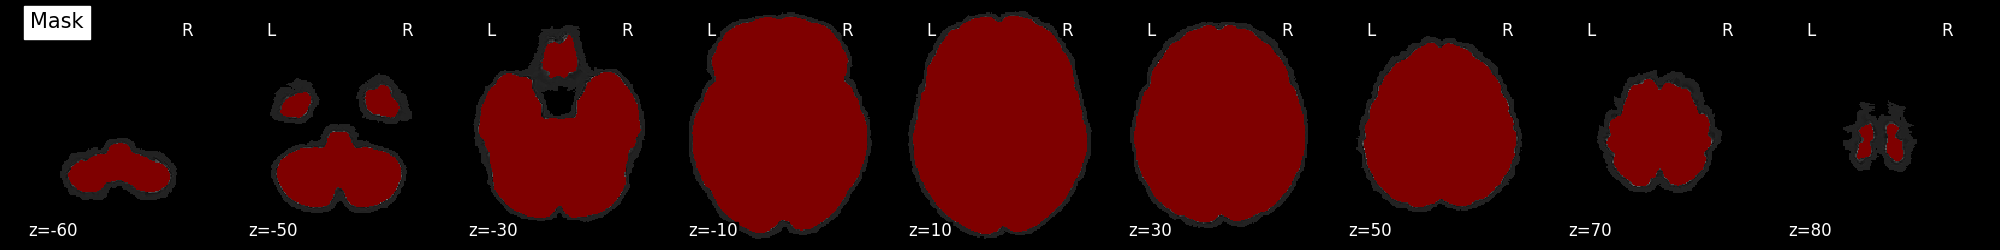

In [22]:
now = datetime.now()
print('Making a mask for analysis:',now.strftime("%H:%M:%S"))
# -------------------
import pandas as pd
import numpy as np
from nilearn.image import new_img_like, load_img
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import decoding
from nilearn.decoding import SearchLight
from sklearn import naive_bayes, model_selection #import GaussianNB

#########################################################################
#Make a mask with the whole brain

mask_wb_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0116/anat/sub-0116_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0116/anat/sub-0116_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
#Load the whole brain mask
mask_img = load_img(mask_wb_filename)


# .astype() makes a copy.
process_mask = mask_img.get_fdata().astype(int)
#Set slices below x in the z-dimension to zero (in voxel space)
process_mask[..., :10] = 0
#Set slices above x in the z-dimension to zero (in voxel space)
process_mask[..., 170:] = 0
process_mask_img = new_img_like(mask_img, process_mask)


#Plot the mask on an anatomical background
plot_img(process_mask_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Mask", display_mode="z",cut_coords=[-60,-50,-30,-10,10,30,50,70,80],
         vmin=.40, cmap='jet', threshold=0.9, black_bg=True)




## Run the searchlight analysis

Note. This takes many hours for one participant. I strongly recommond running this in tmux (see notebook folder for info).

In [24]:
now = datetime.now()
print('Starting searchlight analysis:',now.strftime("%H:%M:%S"))
#n_jobs=-1 means that all CPUs will be used

from nilearn.decoding import SearchLight
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(
    mask_img,
    estimator=GaussianNB(),
    process_mask_img=process_mask_img,
    radius=5, n_jobs=-1,
    verbose=10, cv=10)
searchlight.fit(fmri_img_train, conditions_train)

now = datetime.now()
print('Finishing searchlight analysis:',now.strftime("%H:%M:%S"))

Starting searchlight analysis: 13:40:39


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 76.0min remaining: 227.9min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 76.5min remaining: 127.5min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 76.5min remaining: 76.5min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 78.2min remaining: 46.9min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 79.6min remaining: 26.5min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 80.8min finished


Finishing searchlight analysis: 17:22:19


## Save/restore the variables

In [25]:
import pickle
import nilearn

#Save the searchlight model

# Saving the objects:
f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight.pkl', 'wb')
pickle.dump([searchlight, searchlight.scores_], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight.pkl', 'rb')
#searchlight,searchlight_scores_ = pickle.load(f)
#f.close()


# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_testtrain.pkl', 'rb')
#fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test= pickle.load(f)
#f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_one_sub_all_trials_searchlightNB.pkl', 'rb')
#searchlight,searchlight_scores_ = pickle.load(f)
#f.close()


now = datetime.now()
print('Searchlight output saved:',now.strftime("%H:%M:%S"))


Searchlight output saved: 17:22:19


## Plot the outcome of the searchlight analysis

Plotting and saving searchlight output (threshold:0.6): 17:22:19


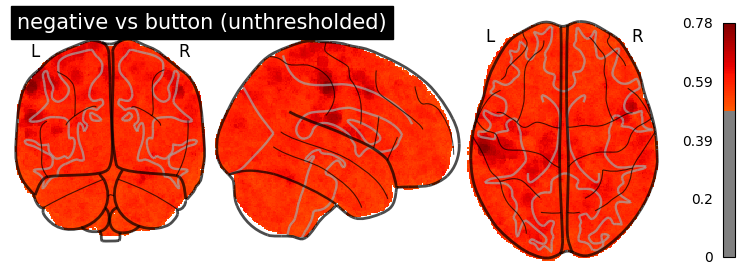

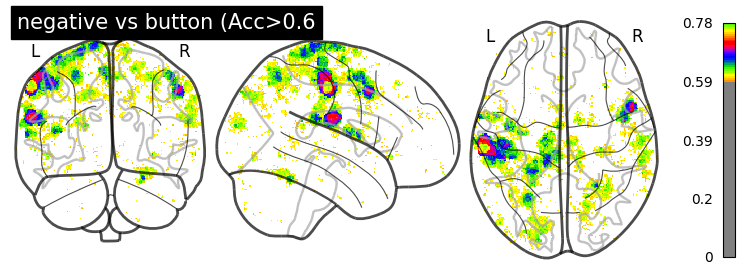

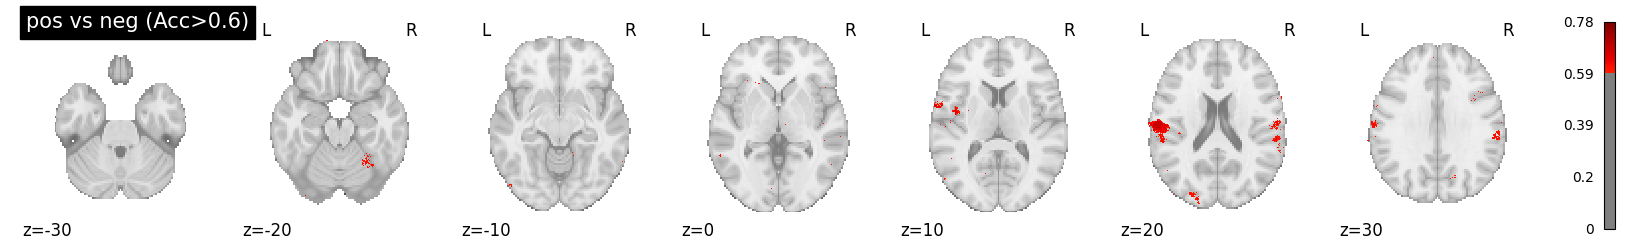

In [26]:
from nilearn import image, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, load_img
mask_wb_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0116/anat/sub-0116_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0116/anat/sub-0116_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

now = datetime.now()
print('Plotting and saving searchlight output (threshold:0.6):',now.strftime("%H:%M:%S"))

#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)


plot_glass_brain(searchlight_img, cmap='jet',colorbar=True, threshold=0.5,
                          title='negative vs button (unthresholded)',
                          plot_abs=False)

fig=plotting.plot_glass_brain(searchlight_img,cmap='prism',colorbar=True,threshold=0.60,title='negative vs button (Acc>0.6')
fig.savefig("/work/MikkelWallentin#6287/InSpe_neg_vs_but_searchlightNB_glass.png", dpi=300)
#plt.show()

plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='pos vs neg (Acc>0.6)')
plt.show()

### Find the 500 most predictive voxels 

In [27]:
print('Number of voxels in searchlight: ',searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 500 best voxels
perc=100*(1-500.0/searchlight.scores_.size)
#Print percentile
print('Percentile for 500 most predictive voxels: ',perc)
#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print('Cutoff for 500 most predictive voxels: ', cut)
#cut=0
#Make a mask using cutoff

#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_fdata().astype(int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)



Number of voxels in searchlight:  8980290
Percentile for 500 most predictive voxels:  99.9944322510743
Cutoff for 500 most predictive voxels:  0.7116995073891625


/tmp/ipykernel_1255/642982622.py:19: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask2_img = new_img_like(mask_img2, process_mask2)


### Visualization of the voxels

/work/798873/virt_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


Saving glass brain with 500 most predictive voxels: 17:22:33


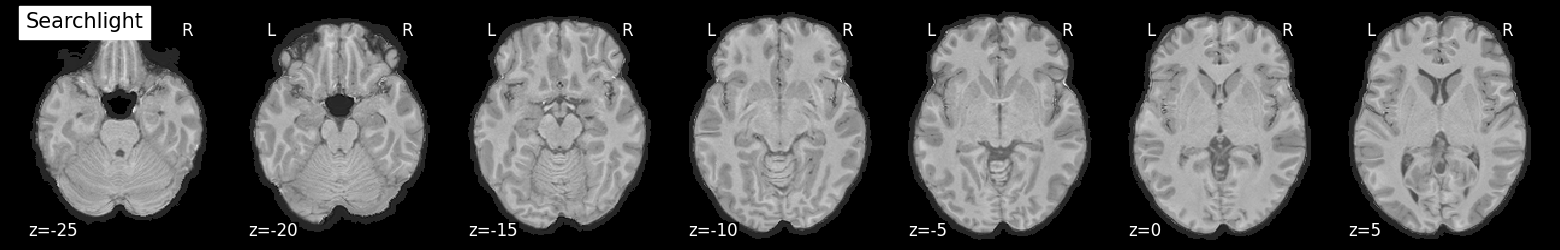

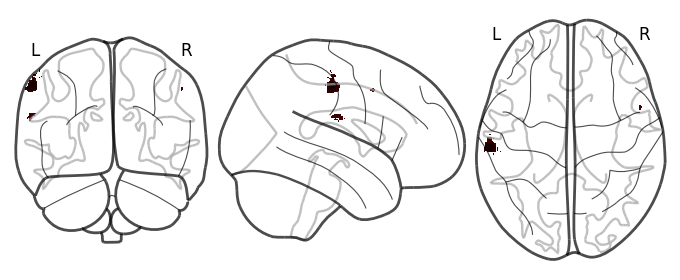

In [28]:
# --------------
from nilearn import image
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import plotting
%matplotlib inline
#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)
#Plot the searchlight scores on an anatomical background
plot_img(searchlight_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Searchlight", display_mode="z",cut_coords=[-25,-20,-15,-10,-5,0,5],
         vmin=.40, cmap='jet', threshold=cut, black_bg=True)
#plotting.plot_glass_brain effects
fig=plotting.plot_glass_brain(searchlight_img,threshold=cut)
fig.savefig("/work/MikkelWallentin#6287/InSpe_neg_vs_but_searchlightNB_glass_500.png", dpi=300)

now = datetime.now()
print('Saving glass brain with 500 most predictive voxels:',now.strftime("%H:%M:%S"))

### Make a permutation classification test on the 2nd data split using the best voxels

In [29]:
now = datetime.now()
print('Perform permutation test on test set using 500 predictive voxels:',now.strftime("%H:%M:%S"))
from sklearn.naive_bayes import GaussianNB
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=process_mask2_img, standardize=False)

# We use masker to retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_img_test)
#Print size of matrix (images x voxels)
print(fmri_masked.shape)

from sklearn.model_selection import permutation_test_score
score_cv_test, scores_perm, pvalue= permutation_test_score(
    GaussianNB(), fmri_masked, conditions_test, cv=10, n_permutations=1000, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score_cv_test, pvalue))



Perform permutation test on test set using 500 predictive voxels: 17:22:34


/work/798873/virt_env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/work/798873/virt_env/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(72, 499)
Classification Accuracy: 0.7910714285714285 (pvalue : 0.000999000999000999)


## Saving permutation outcomes

In [30]:
import pickle

now = datetime.now()
print('Saving permutation scores:',now.strftime("%H:%M:%S"))
#Save the permutation scores

# Saving the objects:
f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'wb')
pickle.dump([score_cv_test, scores_perm, pvalue], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'rb')
#score_cv_test, scores_perm, pvalue = pickle.load(f)
#f.close()



Saving permutation scores: 17:22:45


### View a histogram of permutation scores

Plotting and saving permutation scores: 17:22:45


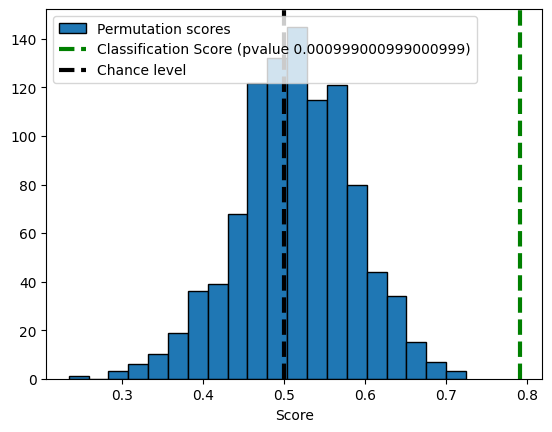

In [31]:
now = datetime.now()
print('Plotting and saving permutation scores:',now.strftime("%H:%M:%S"))

import numpy as np
import matplotlib.pyplot as plt
#How many classes
n_classes = np.unique(conditions_test).size

plt.hist(scores_perm, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score_cv_test], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

plt.savefig("/work/MikkelWallentin#6287/InSpe_neg_vs_pos_one_sub_perm.png", dpi=300)
plt.show()

[NbConvertApp] Converting notebook /work/857248/16_Nilearn_InSpe_classification_single_sub.ipynb to python
[NbConvertApp] Writing 18672 bytes to /work/857248/16_Nilearn_InSpe_classification_single_sub.py
